# Cell Centered Stencil using unstructured LDC

In [1]:
from meshpy import triangle, geometry
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.mesher import *
from src.environment import *
from src.dynamics import *
from src.refiner import MeshRefiner
from tqdm import tqdm

## Building Geometry

In [2]:
builder = geometry.GeometryBuilder()

Add Circle

In [3]:
# points,facets,_,facet_markers = geometry.make_circle(.5,(0.0,0.0),marker = 1)
# builder.add_geometry(points,facets,facet_markers=facet_markers)

Add Box

In [4]:
points,facets,_,_ = geometry.make_box((0, 0), (2.0, 2.0))#,subdivisions=(200, 200))
builder.add_geometry(points,facets, facet_markers=1)

## Setting Mesh Info

In [5]:
info = triangle.MeshInfo()
builder.set(info)
#info.set_holes([(0.0, 0.0)]) # Sets center circle as a hole

Meshing

In [6]:
mesh = triangle.build(info,min_angle=33.0,
                      max_volume=.0001,
                      generate_faces=True,
                      generate_neighbor_lists=True,
                      attributes=True,
                      volume_constraints=True)

In [7]:
np.array(mesh.elements).shape

(68734, 3)

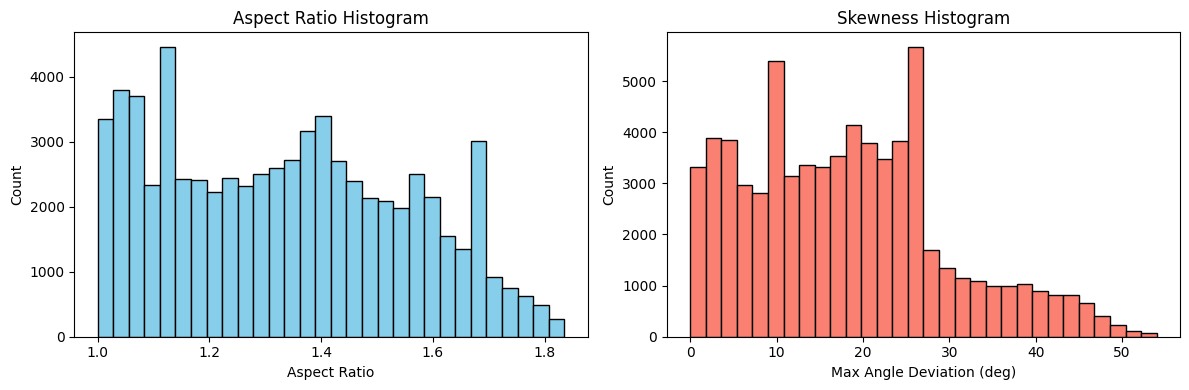

Number of cells with aspect ratio > 3.0: 0
Number of cells with skewness > 30.0°: 9636
Maximum skewness: 54.00
Iteration 1: 9636 bad triangles, max skewness: 54.00, elements: 68734, elapsed: 20.098s
Iteration 2: 2203 bad triangles, max skewness: 56.20, elements: 80090, elapsed: 20.914s
Iteration 3: 1275 bad triangles, max skewness: 53.71, elements: 82833, elapsed: 21.528s
Iteration 4: 981 bad triangles, max skewness: 55.11, elements: 84481, elapsed: 22.198s
Global remeshing performed at iteration 5
Iteration 5: 847 bad triangles, max skewness: 52.46, elements: 86030, elapsed: 21.767s
Iteration 6: 797 bad triangles, max skewness: 50.92, elements: 87869, elapsed: 21.647s
Iteration 7: 653 bad triangles, max skewness: 51.46, elements: 88746, elapsed: 22.349s
Iteration 8: 580 bad triangles, max skewness: 53.39, elements: 89495, elapsed: 23.315s
Iteration 9: 496 bad triangles, max skewness: 51.90, elements: 90374, elapsed: 24.090s
Global remeshing performed at iteration 10
Iteration 10: 495 

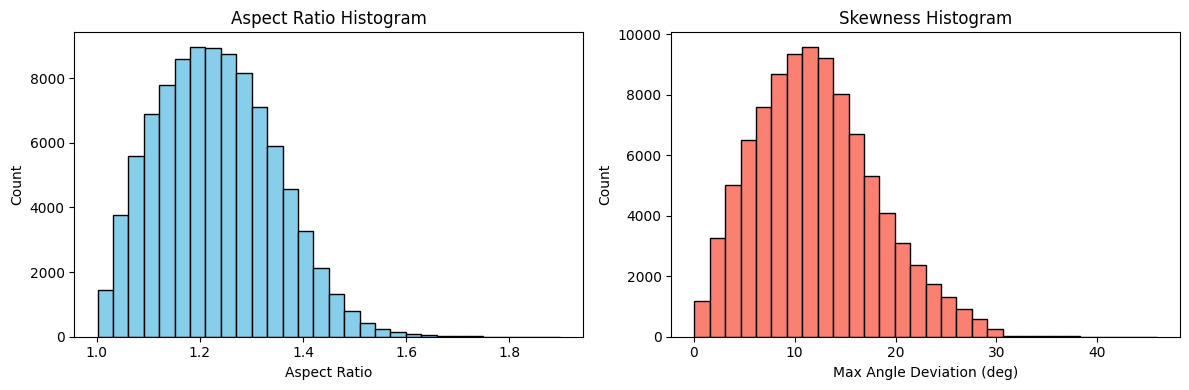

Number of cells with aspect ratio > 3.0: 0
Number of cells with skewness > 30.0°: 113
Maximum skewness: 45.89


In [8]:
improver = MeshRefiner(mesh)
improver.show_mesh_quality()
mesh = improver.improve(aspect_thresh=3.0,
                        skew_thresh=30.0,
                        max_volume=0.0001,
                        move_fraction=.25,
                        max_iter=40)
improver.show_mesh_quality()

## Plotting

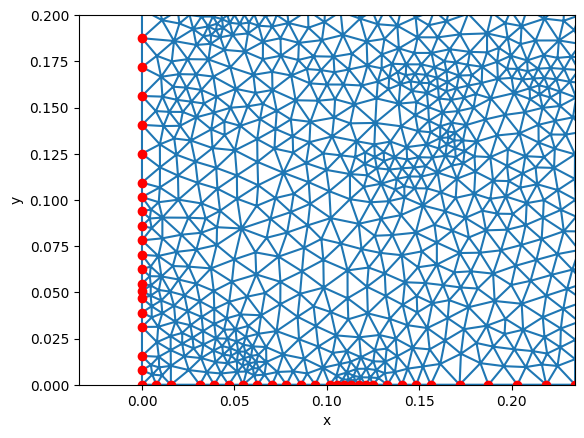

In [9]:
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_attr = np.array(mesh.point_markers)

import matplotlib.pyplot as plt

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.xlabel("x")
plt.ylabel("y")
#
n = np.size(mesh_attr)
inner_nodes = [i for i in range(n) if mesh_attr[i] == 1]
outer_nodes = [i for i in range(n) if mesh_attr[i] == 3]
plt.plot(mesh_points[inner_nodes, 0], mesh_points[inner_nodes, 1], "ro")
plt.plot(mesh_points[outer_nodes, 0], mesh_points[outer_nodes, 1], "go")
plt.axis("equal")
plt.axis([0,.2,0,.2])
plt.show()

In [10]:
import sys
sys.path.append('..')
from src.mesher import *
from src.environment import *
from src.dynamics import *
mesher = Mesher()
mesher.import_meshpy(mesh)

In [11]:
mesher.calc_mesh_properties()

Calculating cell centers...
Cell centers calculated. (Elapsed: 0.143s)
Enforcing boundary face normals outward...
Boundary face normals enforced. (Elapsed: 0.348s)
Calculating face centers...
Face centers calculated. (Elapsed: 0.146s)
Calculating face normals...
Face normals calculated. (Elapsed: 0.356s)
Calculating face lengths...
Face lengths calculated. (Elapsed: 0.203s)
Calculating cell face indices and normals...
Cell face indices and normals calculated. (Elapsed: 1.456s)
Calculating cell face normal signs...
Cell face normal signs calculated. (Elapsed: 0.199s)
Calculating stencil norms (cell-to-cell/cell-to-face)...
Flipping 142159 stencil norms to align with face normals.
Stencil norms calculated. (Elapsed: 0.504s)
Calculating face cell indices...
Face cell indices calculated. (Elapsed: 0.962s)
Calculating face ghost distances...
Face ghost distances calculated. (Elapsed: 0.001s)
Calculating point cell indices and distances...
Point cell indices and distances calculated. (Elapse

In [12]:
mesher.verify_stencil_geometry()

Mean angle (deg): 3.70, max: 30.07
Faces with angle > 30 deg: 1
Mean distance error: 0.0000, max: 0.0000
Mean distance error (% of face length): 0.00%, max: 0.00%
Faces with distance error > 1% of face length: 0
Mean face center offset: 5.2798e-04, max: 2.3528e-03
Mean face center offset (% of face length): 5.68%, max: 20.56%
Faces with face center offset > 10% of face length: 13654
Mean (cell center dist - face dist sum) as % of face length: 2.0022e-01%, max: 8.8439e+00%, min: 0.0000e+00%

Stencil distance checks:
Mean |face-normal dist - stencil-normal dist|: 9.4320e-06, max: 4.5073e-04
Mean |face-normal dist - stencil-normal dist| (% of face length): 0.10%, max: 4.42%
Faces with |face-normal dist - stencil-normal dist| > 1.0%: 1410
Faces with sign mismatch between face-normal and stencil-normal projected distances: 0


Diagonal node index: 33499, coordinates: [0.00558717 0.00548684]
Cell indices on diagonal node 33499: [0, 1, 3, 5, 8, 14]
Face 0: Center=[0.00279359 0.00274342], Face Normal=[-0.70067157  0.71348396], Stencil Normal=[-0.70710678  0.70710678], Distances=[0.0018296  0.00185325], Point Plus=[0.00148314 0.00405387], Point Minus=[0.00408731 0.0014497 ]
Face 1: Center=[0.00279359 0.00664967], Face Normal=[-0.38428721 -0.92321359], Stencil Normal=[-0.4097718  -0.91218807], Distances=[0.00150242 0.00240349], Point Plus=[0.0018087  0.00445723], Point Minus=[0.00340924 0.00802016]
Face 2: Center=[0.         0.00390625], Face Normal=[-1.  0.], Stencil Normal=[-0.9622369  -0.27221344], Distances=[0.00193548 0.00193548], Point Plus=[-0.00186239  0.00337939], Point Minus=[0.00186239 0.00443311]
Face 0: Center=[0.00279359 0.00274342], Face Normal=[-0.70067157  0.71348396], Stencil Normal=[-0.70710678  0.70710678], Distances=[0.0018296  0.00185325], Point Plus=[0.00148314 0.00405387], Point Minus=[0.0

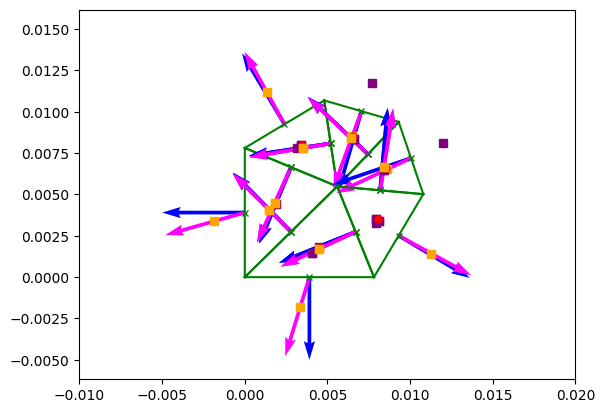

In [13]:
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)

# Find the node at (0, 0)
corner_node = np.where((mesher.points[:, 0] == 0) & (mesher.points[:, 1] == 0))[0][0]
corner_coords = mesher.points[corner_node]
# Find all nodes with both coordinates greater than corner_coords
candidates = np.where((mesher.points[:, 0] > corner_coords[0]) & (mesher.points[:, 1] > corner_coords[1]))[0]
if len(candidates) > 0:
    # Find the candidate with minimal distance to (0,0)
    dists = np.linalg.norm(mesher.points[candidates] - corner_coords, axis=1)
    diagonal_node = candidates[np.argmin(dists)]
    print(f"Diagonal node index: {diagonal_node}, coordinates: {mesher.points[diagonal_node]}")
else:
    print("No diagonal node found.")
    diagonal_node = None

if diagonal_node is not None:
    # Find all cells that include the diagonal node
    cells_on_diagonal_node = [i for i, cell in enumerate(mesher.cells) if diagonal_node in cell]
    print(f"Cell indices on diagonal node {diagonal_node}: {cells_on_diagonal_node}")
else:
    cells_on_diagonal_node = []

for cell_index in cells_on_diagonal_node:
    face_indices = mesher.cell_face_indices[cell_index]
    face_centers = mesher.face_centers[face_indices]
    face_normals = mesher.face_normals[face_indices]
    stencil_normals = mesher.stencil_norms[face_indices]
    for i, (fc, nrm, snrm, dist) in enumerate(zip(face_centers, face_normals, stencil_normals, mesher.cc_stencil_dist[face_indices])):
        # Plot points along the stencil normal direction
        pt_plus = fc + snrm * dist[1]  # outward from cell center to face (stencil direction)
        pt_minus = fc - snrm * dist[0] # inward toward cell center (stencil direction)
        print(f"Face {i}: Center={fc}, Face Normal={nrm}, Stencil Normal={snrm}, Distances={dist}, Point Plus={pt_plus}, Point Minus={pt_minus}")
        plt.plot([pt_plus[0]], [pt_plus[1]], marker='s', color='orange', markersize=6, label='Outward Stencil' if i == 0 else "")
        plt.plot([pt_minus[0]], [pt_minus[1]], marker='s', color='purple', markersize=6, label='Inward Stencil' if i == 0 else "")

    plt.triplot(x, y, tri[cell_index:cell_index + 1], color="g")
    plt.plot(mesher.cell_centers[cell_index, 0], mesher.cell_centers[cell_index, 1], marker='o', color='red', markersize=5, label='Cell Center')
    plt.plot(face_centers[:, 0], face_centers[:, 1], marker='x', color='green', markersize=5, label='Face Center', linestyle='None')
    # Plot both face normals (blue) and stencil normals (magenta)
    plt.quiver(face_centers[:, 0], face_centers[:, 1], face_normals[:, 0], face_normals[:, 1], color='blue', angles='xy', scale_units='xy', scale=200, label='Face Normals')
    plt.quiver(face_centers[:, 0], face_centers[:, 1], stencil_normals[:, 0], stencil_normals[:, 1], color='magenta', angles='xy', scale_units='xy', scale=200, label='Stencil Normals')
plt.axis('equal')
plt.axis([-.01, .02, -.01, .02])
plt.show()

In [44]:
# Given physical parameters
Re = 100            # Reynolds number
nu = 0.1     # physical kinematic viscosity
L = 100             # domain length (physical units)
dx = 1           # spatial step (physical units)
dt = .1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Convert to lattice units
U_lattice = Re * nu / L

# Compute relaxation time tau
Tau = nu / c_s_sq + 0.5

# Print results
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice
dynamics = D2Q9(tau=Tau,delta_t = dt)

Lid velocity (lattice units): 0.10000
Relaxation time tau: 0.80000


In [45]:
cells,faces,nodes = mesher.to_env(dynamics,flux_method="cc_lax_wendroff")
env = Environment(cells,faces,nodes)
env.init()

/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:435: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.n = jnp.array(self.stencil_norms,dtype=jnp.float64)
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:436: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.alpha = jnp.array(self.face_stencil_angles,dtype=jnp.float64)[...,jnp.newaxis]
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src

In [46]:
for i in tqdm(range(10)):
    env = env.step()

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


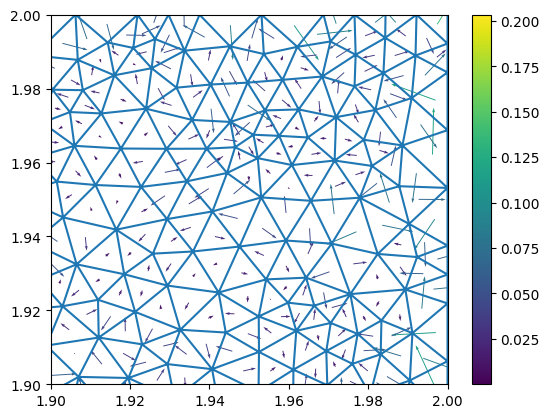

In [48]:
xy = np.array(mesher.cell_centers)
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],mag,scale=1)
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)
plt.triplot(x,y,tri)
plt.axis([1.9,2,1.9,2])
#plt.axis([-1,-.9,-1,-.9])
plt.colorbar()
plt.show()

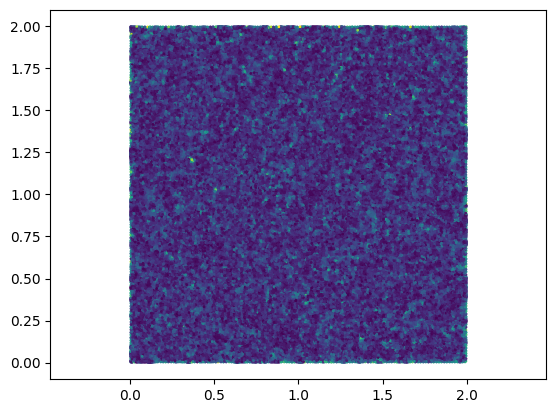

In [49]:
xy = np.array(mesher.cell_centers)
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x, y, c=mag, cmap='viridis', vmin=0, vmax=jnp.max(mag), s=1, marker='o')
plt.axis('equal')
plt.show()

In [25]:
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(xy, vel)

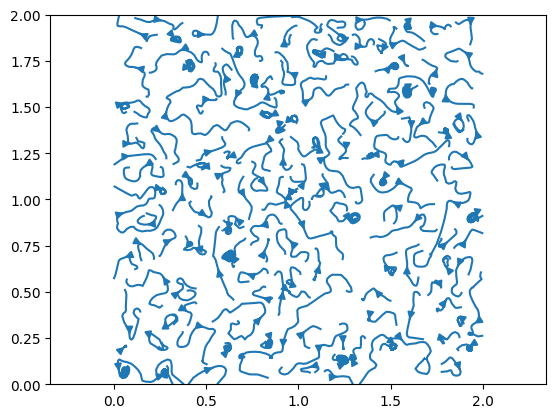

In [26]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.streamplot(x, y, vel[:,:,0], vel[:,:,1],density=1)
plt.axis('equal')
plt.show()

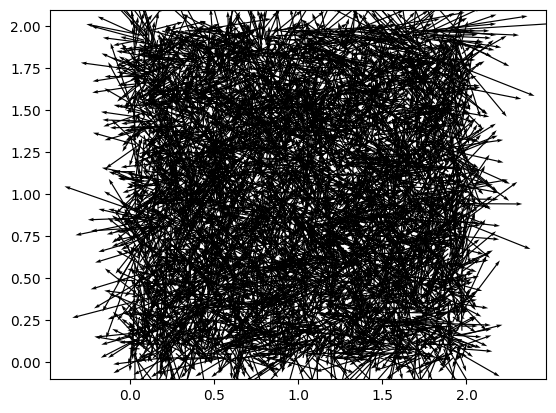

In [27]:
x = np.linspace(0, 2, 75)
y = np.linspace(0, 2, 75)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.quiver(x,y,vel[:,:,0],vel[:,:,1],scale=1)
plt.axis('equal')
plt.show()

In [28]:
from scipy.io import loadmat
ref_data = loadmat('../ref/ldc_Re100.mat')
refu = ref_data['u'].T[...,jnp.newaxis]
refv = ref_data['v'].T[...,jnp.newaxis]
refx = ref_data['x'].squeeze()
refy = ref_data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)
solx = sol[128,:,1]
soly = sol[:,128,0]

In [29]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
outx = interp(x,np.ones_like(x))[...,1]/U_lid
outy = interp(np.ones_like(y),y)[...,0]/U_lid

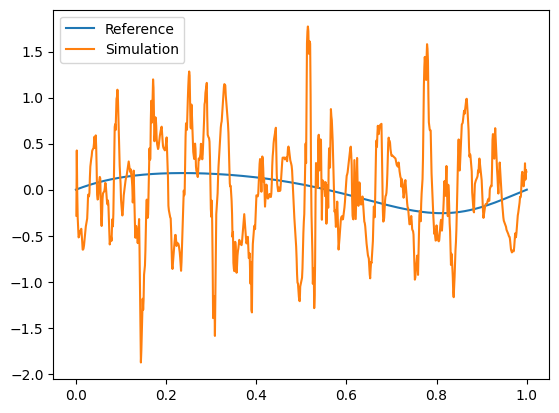

In [30]:
plt.plot(refy,solx)
plt.plot(x/2,outx)
plt.legend(['Reference','Simulation'])
plt.show()

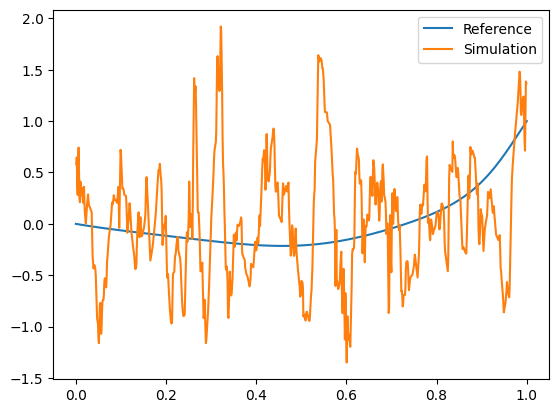

In [31]:
plt.plot(refy,soly)
plt.plot(y/2,outy)
plt.legend(['Reference','Simulation'])
plt.show()

# Tri mesh test


In [50]:
from scipy.io import loadmat
data = loadmat("IRTmesh.mat")

In [51]:
mesher = Mesher()
mesher.points = np.array([data["NODE"][0,i][2][0][:,0] for i in range(data["NODE"].shape[1])], dtype=np.float64)
mesher.cells = np.array([[data["CELL"][0,i][j][0][0][0] for j in range(6,9)] for i in range(data["CELL"].shape[1])],dtype=np.int32)-1
mesher.faces = np.array([[data["FACE"][0,i][j][0][0][0] for j in range(7,9)] for i in range(data["FACE"].shape[1])],dtype=np.int32)-1
mesher.point_markers = np.zeros_like(mesher.points[:,0])

mesher.enforce_ccw()

print(mesher.points.shape, mesher.cells.shape, mesher.faces.shape, mesher.point_markers.shape)

mesher.calc_mesh_properties()

(20201, 2) (40000, 3) (60200, 2) (20201,)
Calculating cell centers...
Cell centers calculated. (Elapsed: 0.054s)
Enforcing boundary face normals outward...
Boundary face normals enforced. (Elapsed: 0.122s)
Calculating face centers...
Face centers calculated. (Elapsed: 0.062s)
Calculating face normals...
Face normals calculated. (Elapsed: 0.136s)
Calculating face lengths...
Face lengths calculated. (Elapsed: 0.089s)
Calculating cell face indices and normals...
Cell face indices and normals calculated. (Elapsed: 0.594s)
Calculating cell face normal signs...
Cell face normal signs calculated. (Elapsed: 0.087s)
Calculating stencil norms (cell-to-cell/cell-to-face)...
Flipping 39900 stencil norms to align with face normals.
Stencil norms calculated. (Elapsed: 0.245s)
Calculating face cell indices...
Face cell indices calculated. (Elapsed: 0.391s)
Calculating face ghost distances...
Face ghost distances calculated. (Elapsed: 0.000s)
Calculating point cell indices and distances...
Point cell 

In [52]:
mesher.verify_stencil_geometry()

Mean angle (deg): 0.00, max: 0.00
Faces with angle > 30 deg: 0
Mean distance error: 0.0000, max: 0.0000
Mean distance error (% of face length): 0.00%, max: 0.00%
Faces with distance error > 1% of face length: 0
Mean face center offset: 1.5766e-03, max: 2.3570e-03
Mean face center offset (% of face length): 11.15%, max: 16.67%
Faces with face center offset > 10% of face length: 40000
Mean (cell center dist - face dist sum) as % of face length: 5.4337e-16%, max: 1.2266e-14%, min: -2.4533e-14%

Stencil distance checks:
Mean |face-normal dist - stencil-normal dist|: 1.7575e-19, max: 1.7347e-18
Mean |face-normal dist - stencil-normal dist| (% of face length): 0.00%, max: 0.00%
Faces with |face-normal dist - stencil-normal dist| > 1.0%: 0
Faces with sign mismatch between face-normal and stencil-normal projected distances: 0


In [58]:
# Given physical parameters
Re = 100            # Reynolds number
nu = 0.1     # physical kinematic viscosity
L = 100             # domain length (physical units)
dx = 1           # spatial step (physical units)
dt = 0.1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Convert to lattice units
U_lattice = Re * nu / L

# Compute relaxation time tau
Tau = nu / c_s_sq + 0.5

# Print results
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice
dynamics = D2Q9(tau=Tau,delta_t = dt)

Lid velocity (lattice units): 0.10000
Relaxation time tau: 0.80000


In [59]:
cells,faces,nodes = mesher.to_env(dynamics,flux_method="cc_lax_wendroff")
env = Environment(cells,faces,nodes)
env.init()

/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:435: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.n = jnp.array(self.stencil_norms,dtype=jnp.float64)
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesher.py:436: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.alpha = jnp.array(self.face_stencil_angles,dtype=jnp.float64)[...,jnp.newaxis]
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src

In [60]:
for i in tqdm(range(100000)):
    env = env.step()

100%|██████████| 100000/100000 [04:59<00:00, 333.51it/s]


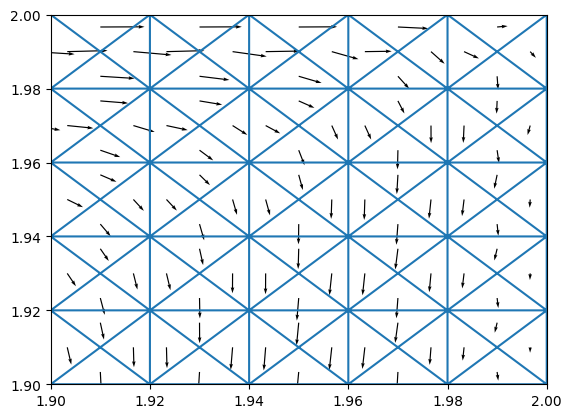

In [61]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],scale=1)
plt.axis([0,.1,0,.1])
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([1.9,2,1.9,2])
plt.show()

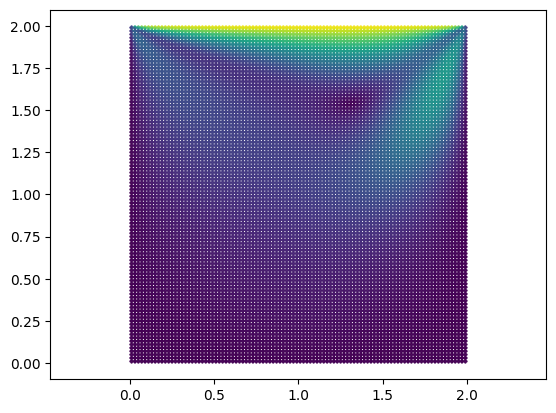

In [62]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x,y,c=mag,cmap='viridis',vmin=0,vmax=U_lid,s=.5)
plt.axis('equal')
plt.show()